In [1]:
!pip install xmltodict

In [2]:
import os
import shutil
from glob import glob
from pathlib import Path, PurePath

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from PIL import Image
import cv2

import  xml.dom.minidom as minidom
import xmltodict

from collections import Counter

from tqdm import tqdm

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.transforms import transforms
from torchvision import datasets, models, transforms

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
ANNOTATIONS = "/kaggle/input/face-mask-detection/annotations"
IMAGES = "/kaggle/input/face-mask-detection/images"

In [5]:
images = glob(IMAGES + "/*")
images = sorted(images)
len(images)

853

In [6]:
annotations = glob(f"{ANNOTATIONS}/*")
annotations = sorted(annotations)
len(annotations)

853

In [7]:
images[0], annotations[0]

('/kaggle/input/face-mask-detection/images/maksssksksss0.png',
 '/kaggle/input/face-mask-detection/annotations/maksssksksss0.xml')

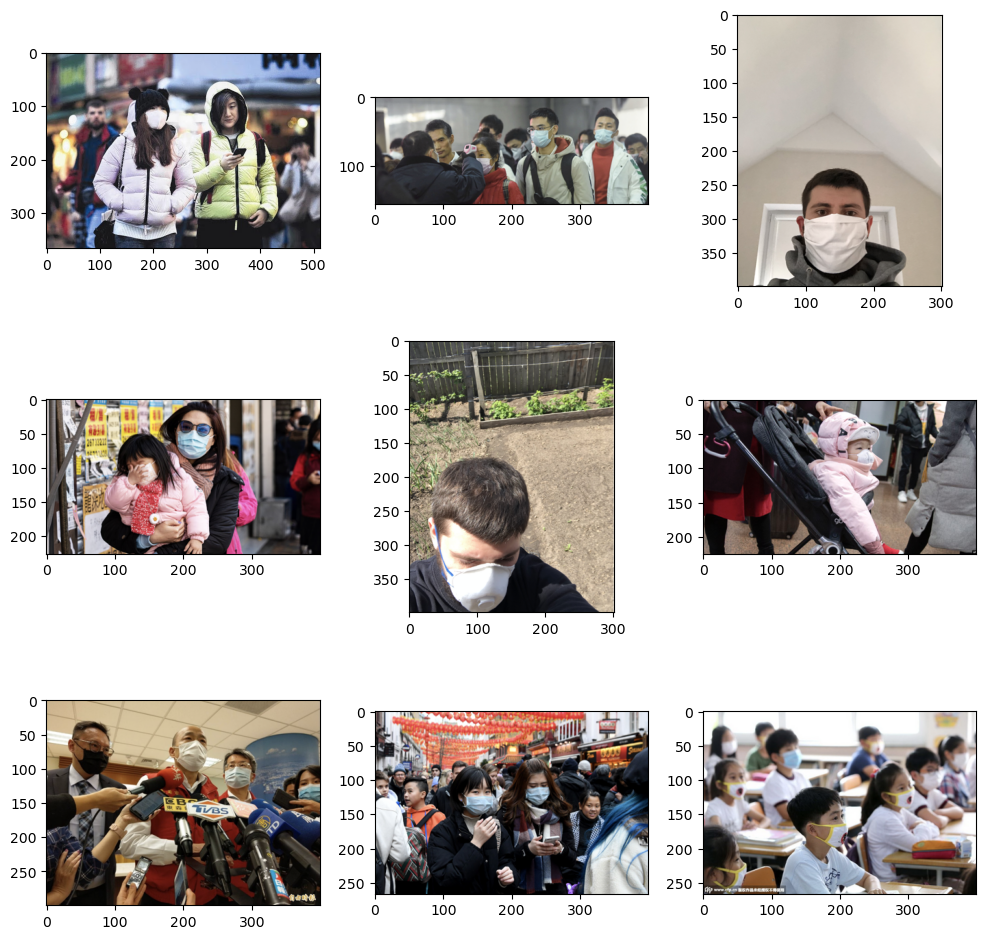

In [8]:
first_nine_images_shape = []
rows, cols = 3, 3
plt.figure(figsize=(12, 12))

for ind, img in enumerate(images):
    if ind==9:
        break
    im = Image.open(img)
    first_nine_images_shape.append(im.size)
    plt.subplot(rows, cols, ind+1)
    plt.imshow(im)
    im.close()

In [9]:
first_nine_images_shape

[(512, 366),
 (400, 156),
 (301, 400),
 (400, 226),
 (301, 400),
 (400, 225),
 (400, 300),
 (400, 267),
 (400, 267)]

# The image dimensions are different so we can resize them to a same dimensions

In [10]:
SIZE = 400

In [11]:
def visualize_xml(annotations, images):
    for i in range(len(images)):
        img_file = images[i]
        xml_file = annotations[i]
        img = cv2.imread(img_file)
        if img is not None:
            dom = minidom.parse(xml_file)
            root = dom.documentElement
            objects = dom.getElementsByTagName("object")
            print(objects)
            j = 0
            for object in objects:
                bndbox = root.getElementsByTagName('bndbox')[j]
                xmin = bndbox.getElementsByTagName('xmin')[0]
                ymin = bndbox.getElementsByTagName('ymin')[0]
                xmax = bndbox.getElementsByTagName('xmax')[0]
                ymax = bndbox.getElementsByTagName('ymax')[0]
                
                xmin_data = xmin.childNodes[0].data
                ymin_data = ymin.childNodes[0].data
                xmax_data = xmax.childNodes[0].data
                ymax_data = ymax.childNodes[0].data
                
                print(object)
                print(xmin_data)
                print(ymin_data)
                
                j += 1
                
                cv2.rectangle(img, 
                              (int(xmin_data), int(ymin_data)), 
                              (int(xmax_data), int(ymax_data)),
                              (55, 255, 155),
                              2
                             )
            cv2.imwrite('/kaggle/working/image.jpg', img)
            break
                
            
    
    

In [12]:
for i in range(len(images)):
    img_file = images[i]
    xml_file = annotations[i]
    img = cv2.imread(img_file)
    if img is not None:
        dom = minidom.parse(xml_file)
        root = dom.documentElement
        objects = dom.getElementsByTagName("object")
        j = 0
        for obj in objects:
            bndbox = root.getElementsByTagName('bndbox')[j]
            xmin = bndbox.getElementsByTagName('xmin')[0]
            ymin = bndbox.getElementsByTagName('ymin')[0]
            xmax = bndbox.getElementsByTagName('xmax')[0]
            ymax = bndbox.getElementsByTagName('ymax')[0]

            xmin_data = xmin.childNodes[0].data
            ymin_data = ymin.childNodes[0].data
            xmax_data = xmax.childNodes[0].data
            ymax_data = ymax.childNodes[0].data

            print(obj)
            print(xmin_data)
            print(ymin_data)

            j += 1

            cv2.rectangle(img, 
                          (int(xmin_data), int(ymin_data)), 
                          (int(xmax_data), int(ymax_data)),
                          (55, 255, 155),
                          2
                         )
#         cv2.imwrite('/kaggle/working/image.jpg', img)
        break

<DOM Element: object at 0x783829651480>
79
105
<DOM Element: object at 0x783829651ab0>
185
100
<DOM Element: object at 0x7838296520e0>
325
90


In [13]:
visualize_xml(annotations, images)

[<DOM Element: object at 0x783829652e60>, <DOM Element: object at 0x783829653490>, <DOM Element: object at 0x783829653ac0>]
<DOM Element: object at 0x783829652e60>
79
105
<DOM Element: object at 0x783829653490>
185
100
<DOM Element: object at 0x783829653ac0>
325
90


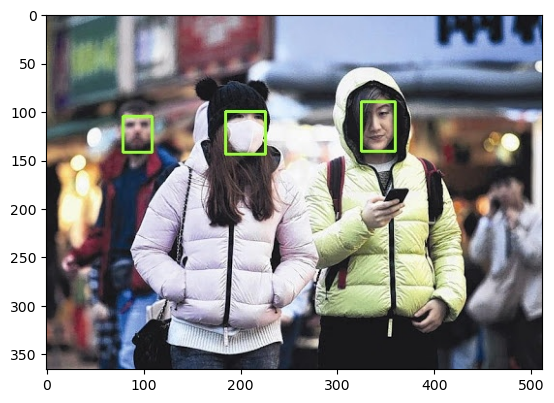

In [14]:
img = Image.open('/kaggle/working/image.jpg')
plt.imshow(img)
img.close()

In [15]:
classes = []
for i in annotations:
    with open(i) as fd:
        doc=xmltodict.parse(fd.read())
    temp = doc['annotation']['object']
    if isinstance(temp, list):
        for i in range(len(temp)):
            classes.append(temp[i]["name"])
    else:
        classes.append(temp["name"])
        
class_label = Counter(classes).keys()
counts = Counter(classes).values()
            

In [16]:
class_label, counts

(dict_keys(['without_mask', 'with_mask', 'mask_weared_incorrect']),
 dict_values([717, 3232, 123]))

In [17]:
 with open("/kaggle/input/face-mask-detection/annotations/maksssksksss0.xml") as fd:
    doc=xmltodict.parse(fd.read())

In [18]:
doc

{'annotation': {'folder': 'images',
  'filename': 'maksssksksss0.png',
  'size': {'width': '512', 'height': '366', 'depth': '3'},
  'segmented': '0',
  'object': [{'name': 'without_mask',
    'pose': 'Unspecified',
    'truncated': '0',
    'occluded': '0',
    'difficult': '0',
    'bndbox': {'xmin': '79', 'ymin': '105', 'xmax': '109', 'ymax': '142'}},
   {'name': 'with_mask',
    'pose': 'Unspecified',
    'truncated': '0',
    'occluded': '0',
    'difficult': '0',
    'bndbox': {'xmin': '185', 'ymin': '100', 'xmax': '226', 'ymax': '144'}},
   {'name': 'without_mask',
    'pose': 'Unspecified',
    'truncated': '0',
    'occluded': '0',
    'difficult': '0',
    'bndbox': {'xmin': '325', 'ymin': '90', 'xmax': '360', 'ymax': '141'}}]}}

In [19]:
img1 = cv2.imread("/kaggle/input/face-mask-detection/images/maksssksksss0.png")


In [20]:
doc['annotation']['object'][0]['bndbox'].values()

dict_values(['79', '105', '109', '142'])

In [21]:
coords = []
labels = []
for i in doc['annotation']['object']:
    bbox = []
    coords.append([int(i['bndbox']['xmin']),
                   int(i['bndbox']['xmax']),
                   int(i['bndbox']['ymin']),
                   int(i['bndbox']['ymax'])])
    labels.append(i['name'])
    

In [22]:
coords

[[79, 109, 105, 142], [185, 226, 100, 144], [325, 360, 90, 141]]

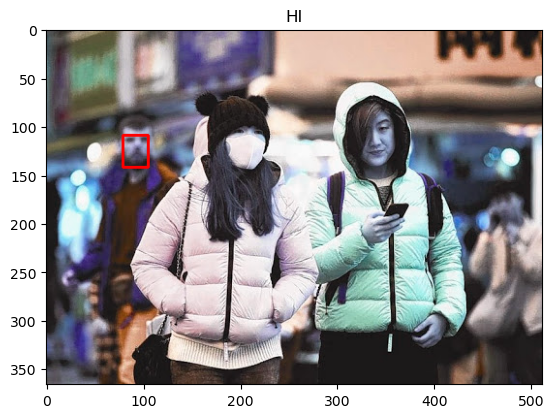

In [23]:

img3 = cv2.rectangle(img1,
              (coords[0][0], coords[0][1]),
              (coords[0][2], coords[0][3]), 
              (255, 0, 0),
              2
             )
plt.title("HI")
plt.imshow(img3)

In [24]:
def plot_coords(coords, color, text, ax):
    x, y, w, h = list(map(int, coords.values()))
    mpatch = mpatches.Rectangle(
        (x ,y),
        w-x, h-y,
        linewidth=1, edgecolor=color, facecolor="none"
    )
    ax.add_patch(mpatch)
    rx, ry = mpatch.get_xy()
    ax.annotate(text, (rx, ry), color=color, weight='bold', fontsize=10, ha='left', va='baseline')
    

In [25]:
def annotate_image(img, xml_file):
    with open(xml_file) as f:
        doc = xmltodict.parse(f.read())
    
    image = plt.imread(img)
    
    fig, ax = plt.subplots(1)
    ax.axis("off")
    fig.set_size_inches(10, 5)
    
    temp = doc['annotation']['object']
    
    if isinstance(temp, list):
        for i in range(len(temp)):
            if temp[i]["name"] == "with_mask":
                plot_coords(temp[i]['bndbox'], 'green', temp[i]["name"],ax)
            
            if temp[i]['name'] == "mask_weared_incorrect":
                plot_coords(temp[i]['bndbox'], 'yellow', temp[i]["name"], ax)
            
            if temp[i]['name'] == "without_mask":
                plot_coords(temp[i]['bndbox'], 'red', temp[i]["name"], ax)
    else:
        x, y, w, h = list(map(int, temp["bndbox"].values()))
        edgecolor = {"with_mask": "g", "without_mask": "r", "mask_weared_incorrect": "y"}
        mpatch = mpatches.Rectangle(
            (x, y),
            w-x, h-y,
            linewidth=1,
            edgecolor=edgecolor[temp["name"]],
            facecolor="none")
        ax.add_patch(mpatch)
        rx, ry = mpatch.get_xy()
        ax.annotate(temp["name"], (rx, ry),
                    color=edgecolor[temp["name"]], weight='bold',
                    fontsize=10, ha='left', va='baseline')
    ax.imshow(image)

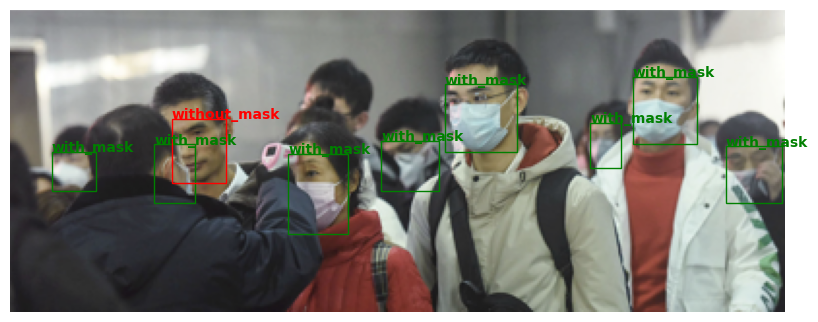

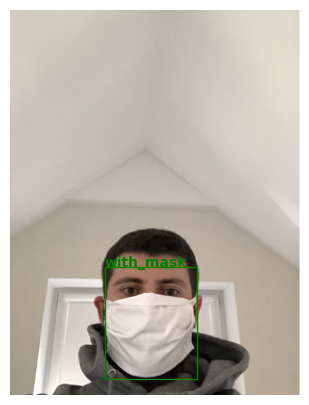

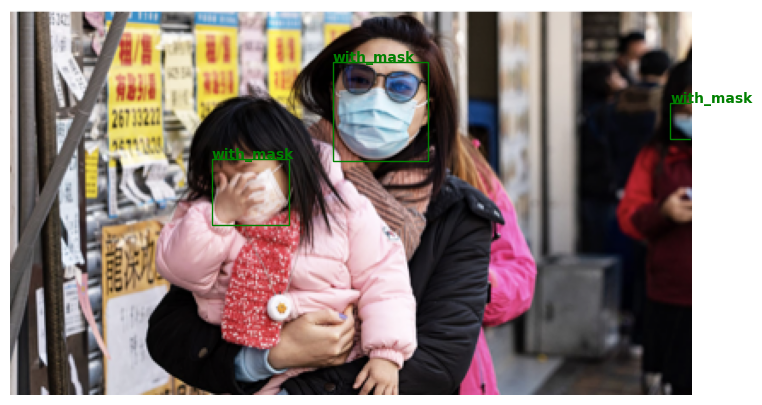

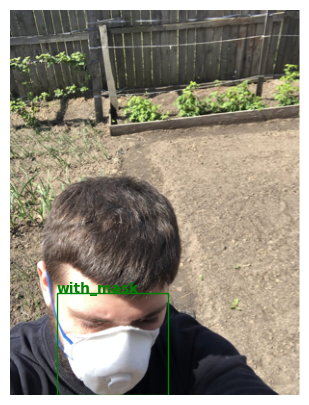

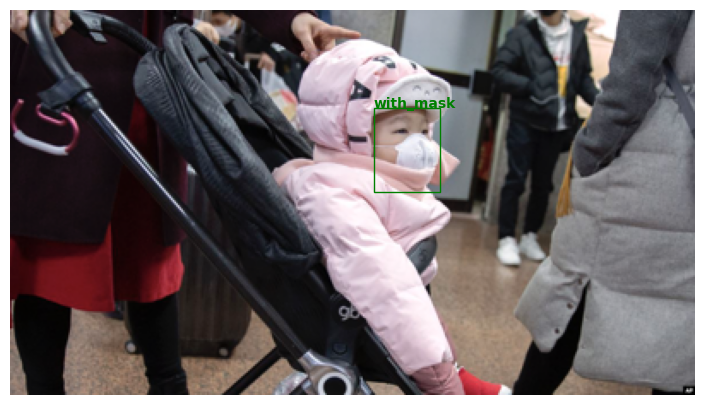

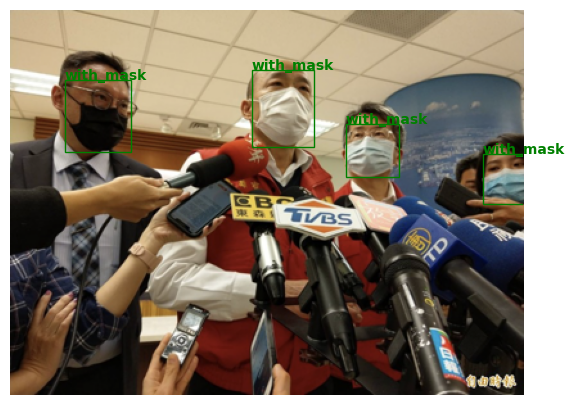

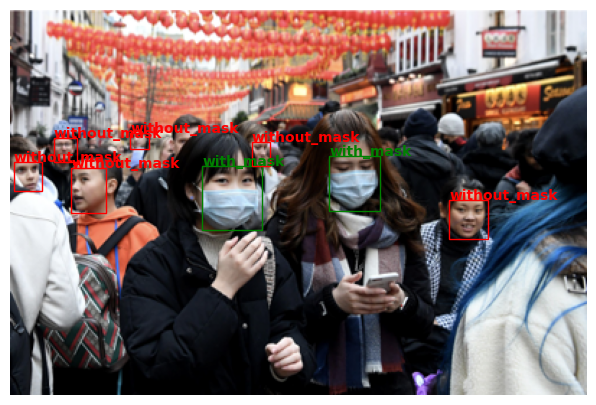

In [26]:
for i in range(1, 8):
    annotate_image(images[i], annotations[i])

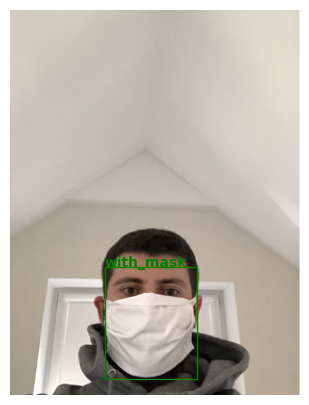

In [27]:
immg = annotate_image("/kaggle/input/face-mask-detection/images/maksssksksss10.png",
              "/kaggle/input/face-mask-detection/annotations/maksssksksss10.xml")

# Dataset

In [28]:
annotated_dataset_folder = "/kaggle/working/annotated_dataset"
os.mkdir(annotated_dataset_folder)


In [29]:
{'annotation': {'folder': 'images',
  'filename': 'maksssksksss0.png',
  'size': {'width': '512', 'height': '366', 'depth': '3'},
  'segmented': '0',
  'object': [{'name': 'without_mask',
    'pose': 'Unspecified',
    'truncated': '0',
    'occluded': '0',
    'difficult': '0',
    'bndbox': {'xmin': '79', 'ymin': '105', 'xmax': '109', 'ymax': '142'}},
   {'name': 'with_mask',
    'pose': 'Unspecified',
    'truncated': '0',
    'occluded': '0',
    'difficult': '0',
    'bndbox': {'xmin': '185', 'ymin': '100', 'xmax': '226', 'ymax': '144'}},
   {'name': 'without_mask',
    'pose': 'Unspecified',
    'truncated': '0',
    'occluded': '0',
    'difficult': '0',
    'bndbox': {'xmin': '325', 'ymin': '90', 'xmax': '360', 'ymax': '141'}}]}}

{'annotation': {'folder': 'images',
  'filename': 'maksssksksss0.png',
  'size': {'width': '512', 'height': '366', 'depth': '3'},
  'segmented': '0',
  'object': [{'name': 'without_mask',
    'pose': 'Unspecified',
    'truncated': '0',
    'occluded': '0',
    'difficult': '0',
    'bndbox': {'xmin': '79', 'ymin': '105', 'xmax': '109', 'ymax': '142'}},
   {'name': 'with_mask',
    'pose': 'Unspecified',
    'truncated': '0',
    'occluded': '0',
    'difficult': '0',
    'bndbox': {'xmin': '185', 'ymin': '100', 'xmax': '226', 'ymax': '144'}},
   {'name': 'without_mask',
    'pose': 'Unspecified',
    'truncated': '0',
    'occluded': '0',
    'difficult': '0',
    'bndbox': {'xmin': '325', 'ymin': '90', 'xmax': '360', 'ymax': '141'}}]}}

In [30]:
# def create_annotated_image(img, vertices, image_path, width, height):
#     imgg = cv2.imread(img)
#     imgg = cv2.resize(imgg, (width, height), interpolation=cv2.INTER_AREA)
#     for i in range(len(vertices)):
#         imgg = cv2.rectangle(imgg,
#                              (int(vertices[i][0]), int(vertices[i][1])),
#                              (int(vertices[i][2]), int(vertices[i][3])),
#                              (255, 0, 0),
#                              2)
#     cv2.imwrite(image_path, imgg)
        

In [31]:

# def create_df(xmls, new_height, new_width, annotated_dataset_folder):
    
#     df = {
#         "image_path": [],
#         "new_image_path": [],
#         "og_width": [],
#         "og_height": [],
#         "new_width": [],
#         "new_height": [],
#         "normalized_vertices": [], # [ [ [x1,y1,x2,y2], [x1,x2,y1,y2] ], [ [], [] ], [ [] ] ]
#         "og_vertices": [],
#         "new_vertices": [],
#         "labels": [] # [ [1, 2, 3], [] ]
#     }
#     for xml_file in xmls:
#         with open(xml_file) as f:
#             doc = xmltodict.parse(f.read())
        
#         img_name = "/kaggle/input/face-mask-detection/images/" + doc['annotation']['filename']
#         width = int(doc['annotation']['size']['width'])
#         height = int(doc['annotation']['size']['height'])
#         temp = doc['annotation']['object']
#         df['image_path'].append(img_name)
#         df['og_width'].append(width)
#         df['og_height'].append(height)
#         df['new_width'].append(new_width)
#         df['new_height'].append(new_height)
#         new_image_path = os.path.join(annotated_dataset_folder, Path(img_name).name)
#         df['new_image_path'].append(new_image_path)
    

#         if isinstance(temp, list):
#             labels = []
#             og_vertices = []
#             new_vertices = []
#             normalized_vertices = []
            
#             for i in range(len(temp)):
#                 labels.append(temp[i]["name"])
#                 x1, y1, x2, y2 = list(map(int, temp[i]['bndbox'].values()))
#                 nv_x1, nv_y1, nv_x2, nv_y2 = x1 / width, y1 / height, x2 / width, y2 / height
#                 n_x1, n_y1, n_x2, n_y2 = nv_x1 * new_width, nv_y1 * new_height, nv_x2 * new_width, nv_y2 * new_height
#                 og_vertices.append([x1, y1, x2, y2])
#                 new_vertices.append([n_x1, n_y1, n_x2, n_y2])
#                 normalized_vertices.append([nv_x1, nv_y1, nv_x2, nv_y2])
                
#             df['labels'].append(labels)
#             df['og_vertices'].append(og_vertices)
#             df['new_vertices'].append(new_vertices)
#             df['normalized_vertices'].append(normalized_vertices)
        
                
#         else:
#             x1, y1, x2, y2 = list(map(int, temp['bndbox'].values()))
#             nv_x1, nv_y1, nv_x2, nv_y2 = x1 / width, y1 / height, x2 / width, y2 / height
#             n_x1, n_y1, n_x2, n_y2 = nv_x1 * new_width, nv_y1 * new_height, nv_x2 * new_width, nv_y2 * new_height
#             df['labels'].append([temp["name"]])
#             df['og_vertices'].append([x1, y1, x2, y2])
#             df['new_vertices'].append([n_x1, n_y1, n_x2, n_y2])
#             df['normalized_vertices'].append([nv_x1, nv_y1, nv_x2, nv_y2])

#         create_annotated_image(img_name, new_vertices, new_image_path, new_width, new_height)
        
    
#     df = pd.DataFrame(df)

#     return df

In [32]:
# IMG_WIDTH, IMG_HEIGHT = 224, 224
# df = create_df(annotations, IMG_HEIGHT, IMG_WIDTH, annotated_dataset_folder)
# df.head()

In [33]:
# df.shape

In [34]:
classes = ['with_mask', 'without_mask', 'mask_weared_incorrect']

In [35]:
for i in classes:
    os.mkdir(os.path.join(annotated_dataset_folder, i))

In [36]:
def plot_images(img, vertices, image_path, width, height):
    imgg = cv2.imread(img)
    imgg = cv2.resize(imgg, (width, height), interpolation=cv2.INTER_AREA)
    for i in range(len(vertices)):
        imgg = cv2.rectangle(imgg,
                             (int(vertices[0]), int(vertices[1])),
                             (int(vertices[2]), int(vertices[3])),
                             (255, 0, 0),
                             2)
    cv2.imwrite(image_path, imgg)
     

In [37]:
class_dict = {"with_mask": 0, "without_mask": 1, "mask_weared_incorrect": 2}

In [42]:

def create_df_uniclass(xmls, new_height, new_width, dataset_folderannotated_dataset_folder):
    
    df = {
#         "image_array": [],
        "image_path": [],
        "new_image_path": [],
        "og_width": [],
        "og_height": [],
        "new_width": [],
        "new_height": [],
        "xmin": [], # [ [ [x1,y1,x2,y2], [x1,x2,y1,y2] ], [ [], [] ], [ [] ] ]
        "xmax": [],
        "ymin": [],
        "ymax": [],
        "classes": [],
        "vertices": [],
        "labels": [] # [ [1, 2, 3], [] ]
    }
    for xml_file in xmls:
        with open(xml_file) as f:
            doc = xmltodict.parse(f.read())
        
        img_name = "/kaggle/input/face-mask-detection/images/" + doc['annotation']['filename']
        width = int(doc['annotation']['size']['width'])
        height = int(doc['annotation']['size']['height'])
        temp = doc['annotation']['object']


        if isinstance(temp, list):

            for i in range(len(temp)):
                df['image_path'].append(img_name)
                df['og_width'].append(width)
                df['og_height'].append(height)
                df['new_width'].append(new_width)
                df['new_height'].append(new_height)

                x1, y1, x2, y2 = list(map(int, temp[i]['bndbox'].values()))
                nv_x1, nv_y1, nv_x2, nv_y2 = x1 / width, y1 / height, x2 / width, y2 / height
                n_x1, n_y1, n_x2, n_y2 = int(nv_x1 * new_width), int(nv_y1 * new_height), int(nv_x2 * new_width), int(nv_y2 * new_height)
                fn_x1, fn_y1, fn_x2, fn_y2 = nv_x1 * new_width, nv_y1 * new_height, nv_x2 * new_width, nv_y2 * new_height
                
                dataset_folder = os.path.join(annotated_dataset_folder, temp[i]["name"])
                new_image_path = os.path.join(dataset_folder, Path(img_name).name)
                df['new_image_path'].append(new_image_path)
#                 imgs = cv2.imread(new_image_path)
#                 df['image_array'].append(imgs)
               
                
                df['labels'].append(temp[i]["name"])
                df['xmax'].append(n_x2)
                df['xmin'].append(n_x1)
                df['ymax'].append(n_y2)
                df['ymin'].append(n_y1)
                df['classes'].append(class_dict[temp[i]["name"]])
                df['vertices'].append([fn_x1, fn_y1, fn_x2, fn_y2])
                plot_images(img_name, [n_x1, n_y1, n_x2, n_y2], new_image_path, new_width, new_height)
            
        else:
            df['image_path'].append(img_name)
            df['og_width'].append(width)
            df['og_height'].append(height)
            df['new_width'].append(new_width)
            df['new_height'].append(new_height)
            x1, y1, x2, y2 = list(map(int, temp['bndbox'].values()))
            nv_x1, nv_y1, nv_x2, nv_y2 = x1 / width, y1 / height, x2 / width, y2 / height
            n_x1, n_y1, n_x2, n_y2 = int(nv_x1 * new_width), int(nv_y1 * new_height), int(nv_x2 * new_width), int(nv_y2 * new_height)
            fn_x1, fn_y1, fn_x2, fn_y2 = nv_x1 * new_width, nv_y1 * new_height, nv_x2 * new_width, nv_y2 * new_height
            dataset_folder = os.path.join(annotated_dataset_folder, temp["name"])
            new_image_path = os.path.join(dataset_folder, Path(img_name).name)
            df['new_image_path'].append(new_image_path)
#             imgs = cv2.imread(new_image_path)
#             df['image_array'].append(imgs)
            
                
            df['labels'].append(temp["name"])
            df['xmax'].append(n_x2)
            df['xmin'].append(n_x1)
            df['ymax'].append(n_y2)
            df['ymin'].append(n_y1)
            df['classes'].append(class_dict[temp["name"]])
            df['vertices'].append([fn_x1, fn_y1, fn_x2, fn_y2])
            plot_images(img_name, [n_x1, n_y1, n_x2, n_y2], new_image_path, new_width, new_height)
    
#     df = pd.DataFrame(df)

    return df

In [43]:
IMG_WIDTH, IMG_HEIGHT = 224, 224
df1 = create_df_uniclass(annotations, IMG_HEIGHT, IMG_WIDTH, annotated_dataset_folder)


libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


In [45]:
df1 = pd.DataFrame(df1)
df1.shape

(4072, 13)

In [46]:
df1.head()

image_path  \
0  /kaggle/input/face-mask-detection/images/makss...   
1  /kaggle/input/face-mask-detection/images/makss...   
2  /kaggle/input/face-mask-detection/images/makss...   
3  /kaggle/input/face-mask-detection/images/makss...   
4  /kaggle/input/face-mask-detection/images/makss...   

                                      new_image_path  og_width  og_height  \
0  /kaggle/working/annotated_dataset/without_mask...       512        366   
1  /kaggle/working/annotated_dataset/with_mask/ma...       512        366   
2  /kaggle/working/annotated_dataset/without_mask...       512        366   
3  /kaggle/working/annotated_dataset/with_mask/ma...       400        156   
4  /kaggle/working/annotated_dataset/with_mask/ma...       400        156   

   new_width  new_height  xmin  xmax  ymin  ymax  classes  \
0        224         224    34    47    64    86        1   
1        224         224    80    98    61    88        0   
2        224         224   142   157    55    86        1   
3        224         224   179   198    48    99        0   
4        224         224   125   146    54   104        0   

                                            vertices        labels  
0  [34.5625, 64.26229508196721, 47.6875, 86.90710...  without_mask  
1  [80.9375, 61.20218579234973, 98.875, 88.131147...     with_mask  
2  [142.1875, 55.08196721311475, 157.5, 86.295081...  without_mask  
3  [179.76, 48.82051282051282, 198.24, 99.0769230...     with_mask  
4  [125.44000000000001, 54.56410256410256, 146.16...     with_mask

In [47]:
img = df1['image_path'][0]
vertices = [df1['xmin'][0], df1['ymin'][0], df1['xmax'][0], df1['ymax'][0]]
image_path = '/kaggle/working/image2.jpg'

In [48]:
df1['labels'][0]

'without_mask'

In [49]:
plot_images(img, vertices, image_path, 224, 224)

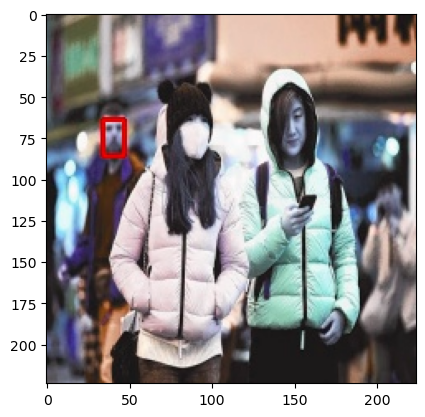

In [50]:
plt.imshow(cv2.imread("/kaggle/working/image2.jpg"));

In [51]:
classes = list((df1['labels'].value_counts()).index)
classes

['with_mask', 'without_mask', 'mask_weared_incorrect']

In [52]:
annotated_dataset_folder

'/kaggle/working/annotated_dataset'

In [53]:
df1.columns

Index(['image_path', 'new_image_path', 'og_width', 'og_height', 'new_width',
       'new_height', 'xmin', 'xmax', 'ymin', 'ymax', 'classes', 'vertices',
       'labels'],
      dtype='object')

In [ ]:
# og_imgs = list(df1['image_path'])
# new_imgs = list(df1['new_image_path'])

In [ ]:
# new_imgs

In [ ]:
# for i in range(len(og_imgs)):
#     shutil.copy(og_imgs[i], new_imgs[i])

In [54]:
train_df, test_df = train_test_split(df1, stratify=df1['classes'], test_size=0.1)
train_df.shape, test_df.shape

((3664, 13), (408, 13))

In [55]:
train_df['labels'].value_counts(), train_df['classes'].value_counts()

(with_mask                2908
 without_mask              645
 mask_weared_incorrect     111
 Name: labels, dtype: int64,
 0    2908
 1     645
 2     111
 Name: classes, dtype: int64)

In [56]:
test_df['labels'].value_counts(), test_df['classes'].value_counts()

(with_mask                324
 without_mask              72
 mask_weared_incorrect     12
 Name: labels, dtype: int64,
 0    324
 1     72
 2     12
 Name: classes, dtype: int64)

In [57]:
train_images = train_df['new_image_path'].values
test_images = test_df['new_image_path'].values

# train_images = torch.from_numpy(train_df['image_array'].values)
# test_images = torch.from_numpy(test_df['image_array'].values)

train_labels = torch.from_numpy(train_df['classes'].values)
test_labels = torch.from_numpy(test_df['classes'].values)

train_bbox = torch.from_numpy(train_df[['xmin', 'xmax', 'ymin', 'ymax']].values)
test_bbox = torch.from_numpy(test_df[['xmin', 'xmax', 'ymin', 'ymax']].values)


In [58]:
type(train_images), type(test_images), type(train_labels), type(test_labels), type(test_bbox), type(train_bbox)

(numpy.ndarray,
 numpy.ndarray,
 torch.Tensor,
 torch.Tensor,
 torch.Tensor,
 torch.Tensor)

In [59]:
train_labels

tensor([0, 1, 0,  ..., 0, 0, 0])

In [60]:
type(train_images), type(train_labels)

(numpy.ndarray, torch.Tensor)

In [61]:
# type(train_bbox), type(torch.from_numpy(train_images))

In [62]:
test_bbox

tensor([[137, 152,  15,  38],
        [189, 206,  13,  62],
        [ 81,  94,  98, 122],
        ...,
        [ 72,  79,  77,  85],
        [170, 177,  93, 103],
        [ 49, 115, 161, 224]])

# Create Image DataLoader and Dataset

In [63]:
annotated_dataset_folder

'/kaggle/working/annotated_dataset'

In [64]:
BATCH_SIZE = 32

In [65]:
train = datasets.ImageFolder(annotated_dataset_folder,
                   transform = transforms.Compose([
                       transforms.Resize(IMG_WIDTH),
                       transforms.RandomCrop(IMG_WIDTH),
                       transforms.ToTensor()
                   ]))
train_data_loader = torch.utils.data.DataLoader(train, 32, shuffle=True, num_workers=3, pin_memory=True)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [66]:
def get_mean_std(data_loader):
    sum_, squared_sum, batches = 0, 0, 0
    for data, _ in data_loader:
        sum_ += torch.mean(data, dim=([0, 2, 3]))
        squared_sum += torch.mean(data ** 2, dim=([0, 2, 3]))
        batches += 1
    
    mean = sum_ / batches
    std = (squared_sum / batches - mean ** 2) ** 0.5
    return mean, std

In [67]:
mean, std = get_mean_std(train_data_loader)
mean, std

(tensor([0.4459, 0.4251, 0.4270]), tensor([0.2911, 0.2858, 0.2873]))

In [68]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(IMG_HEIGHT),
    transforms.RandomCrop(IMG_WIDTH),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(IMG_HEIGHT),
    transforms.CenterCrop(IMG_HEIGHT),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])

In [69]:
# class CustomTensorDataset(Dataset):
    
#     def __init__(self, tensors, transforms=None):
#         self.tensors = tensors
#         self.transforms = transforms
    
#     def __getitem__(self, idx):
#         image = self.tensors[0][idx]
#         label = self.tensors[1][idx]
#         bbox = self.tensors[2][idx]
        
#         image = image.permute(2, 0, 1)
        
#         if self.transforms:
#             image = self.transforms(image)
        
#         return (image, label, bbox)
    
#     def __len__(self):
#         return self.tensors[0].shape[0]
    

In [70]:

class CustomTensorDataset(Dataset):
    
    def __init__(self, tensors, transforms=None):
        self.tensors = tensors
        self.transforms = transforms
    
    def __getitem__(self, index):
#         image = self.tensors[0][index]
        label = self.tensors[1][index]
        bbox = self.tensors[2][index]
        
        image = cv2.imread(self.tensors[0][index])
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
#         image = image.permute(2, 0, 1)
        
        if self.transforms:
            image = self.transforms(image)
        
        return (image, label, bbox)
    
    def __len__(self):
        return self.tensors[0].shape[0]


In [71]:
trainset = CustomTensorDataset((train_images, train_labels, train_bbox),
                               transforms=train_transform)
testset = CustomTensorDataset((test_images, test_labels, test_bbox),
                              transforms=test_transform)

In [72]:
testset

In [73]:
len(testset)

408

In [74]:
# datas = datasets.ImageFolder(annotated_dataset_folder,
#                    transform = transforms.Compose([
#                        transforms.Resize(IMG_HEIGHT),
#                        transforms.RandomCrop(IMG_WIDTH),
#                        transforms.ToTensor()
#                    ]))

# train_size=int(len(datas) * 0.9)
# test_size=len(datas) - train_size

# trainset, testset = torch.utils.data.random_split(datas,[train_size, test_size])

In [75]:
len(trainset), len(testset)

(3664, 408)

In [76]:
train_data_loader = torch.utils.data.DataLoader(trainset, BATCH_SIZE, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(testset, BATCH_SIZE, shuffle=True)

In [77]:
# datas = datasets.ImageFolder(annotated_dataset_folder,
#                    transform = transforms.Compose([
#                        transforms.Resize(IMG_HEIGHT),
#                        transforms.RandomCrop(IMG_WIDTH),
#                        transforms.ToTensor()
#                    ]))
# train_idx, test_idx = train_test_split(list(range(len(datas))), test_size=0.1)
# dataset = {}
# dataset['train'] = Subset(datas, train_idx)
# dataset['test'] = Subset(datas, test_idx)


# train_data_loader = torch.utils.data.DataLoader(trainset, BATCH_SIZE, shuffle=True, num_workers=3)
# test_data_loader = torch.utils.data.DataLoader(testset, BATCH_SIZE, shuffle=True, num_workers=3)

# Object Detection

## Here I am trying to build Object detection from scratch using Vanilla CNN and regressor

In [78]:
class ObjectDetection(nn.Module):
    
    def __init__(self, in_channels=3, out_channels_cnn=3, bboxes=4):
        super().__init__()
        hidden_channel1 = 32
        hidden_channel2 = 64
        hidden_channel3 = 128
        kernel_size = 3
        stride = 1
        padding = 1
        self.conv1 = nn.Conv2d(in_channels=in_channels,
                               out_channels=hidden_channel1,
                               kernel_size=kernel_size, 
                               stride=stride, 
                               padding=padding)
        self.conv2 = nn.Conv2d(in_channels=hidden_channel1,
                               out_channels=hidden_channel2,
                               kernel_size=kernel_size, 
                               stride=stride, 
                               padding=padding)
        self.conv3 = nn.Conv2d(in_channels=hidden_channel2,
                               out_channels=hidden_channel2,
                               kernel_size=kernel_size, 
                               stride=stride, 
                               padding=padding)
        self.conv4 = nn.Conv2d(in_channels=hidden_channel2,
                               out_channels=hidden_channel3,
                               kernel_size=kernel_size, 
                               stride=stride, 
                               padding=padding)
        self.conv5 = nn.Conv2d(in_channels=hidden_channel3,
                               out_channels=hidden_channel3,
                               kernel_size=kernel_size, 
                               stride=stride, 
                               padding=padding)
        
        self.batchnorm1 = nn.BatchNorm2d(hidden_channel1)
        self.batchnorm2 = nn.BatchNorm2d(hidden_channel2)
        self.batchnorm3 = nn.BatchNorm2d(hidden_channel3)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU()
        self.fc = nn.Flatten()
        self.cnn_layer = nn.Linear(7*7*128, out_channels_cnn)
        self.regressor = nn.Linear(7*7*128, bboxes)
    
    def cnn_layers(self, x):
        x = self.relu(x)
        x = self.maxpool(x)
        return x
    
    def feature_extractor(self, x):
#         print(x.shape)
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.cnn_layers(x)
#         print(x.shape)
        
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.cnn_layers(x)
#         print(x.shape)
        
        x = self.conv3(x)
        x = self.batchnorm2(x)
        x = self.cnn_layers(x)
#         print(x.shape)
        
        x = self.conv4(x)
        x = self.batchnorm3(x)
        x = self.cnn_layers(x)
#         print(x.shape)
        
        x = self.conv5(x)
        x = self.batchnorm3(x)
        x = self.cnn_layers(x)
#         print(x.shape)
        
        x = self.fc(x)
#         print(x.shape)
        return x
    
    def forward(self, x):
        x = self.feature_extractor(x)
        classifier_op = self.cnn_layer(x)
        regressor_op = self.regressor(x)
        return (regressor_op, classifier_op)
#         out = torch.concat([classifier_op, regressor_op])
#         return out

In [ ]:
# import torch
# import torch.nn as nn

# class ObjectDetection(nn.Module):
    
#     def __init__(self, num_classes, num_anchor_boxes=9, bboxes=4):
#         super().__init__()
#         # ... other initialization code ...

#         # Classification head
#         self.classification_head = nn.Conv2d(in_channels=hidden_channel3,
#                                              out_channels=num_anchor_boxes * num_classes,
#                                              kernel_size=1)

#         # Bounding box regression head
#         self.regression_head = nn.Conv2d(in_channels=hidden_channel3,
#                                          out_channels=num_anchor_boxes * bboxes,
#                                          kernel_size=1)

#         self.softmax = nn.Softmax(dim=1)

#     def forward(self, x):
#         x = self.feature_extractor(x)
#         classification_scores = self.classification_head(x)  # [batch_size, num_boxes * num_classes, h, w]
#         regression_offsets = self.regression_head(x)          # [batch_size, num_boxes * bboxes, h, w]
        
#         return classification_scores, regression_offsets

# # Example usage
# num_classes = 20
# num_anchor_boxes = 9
# bboxes = 4

# model = ObjectDetection(num_classes, num_anchor_boxes, bboxes)

# # Sample input
# batch_size = 1
# channels = 3
# height = 224
# width = 224
# input_data = torch.randn(batch_size, channels, height, width)

# # Forward pass
# classification_scores, regression_offsets = model(input_data)

# # Print shapes of output tensors
# print("Classification scores shape:", classification_scores.shape)
# print("Regression offsets shape:", regression_offsets.shape)


In [79]:
model = ObjectDetection(in_channels=3, out_channels_cnn=3, bboxes=4)
model = model.to(device)

In [80]:
model

ObjectDetection(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (fc): Flatten(start_dim=1, end_dim=-1)
  (cnn_layer): Linear(in_features=6272, out_features=3, bias=True)
  (regressor): Linear(in_features=6272, out_features=4, bias=True)
)

In [81]:
classification_loss_fn = nn.CrossEntropyLoss()
bbox_loss_fn = nn.MSELoss()

In [84]:
LR = 0.001
opt = torch.optim.Adam(model.parameters(), lr=LR)

# Training the model

In [89]:
-4.3980e-01

-0.4398

In [93]:
EPOCHS = 10
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

for epoch in tqdm(range(EPOCHS)):
    correct = 0
    iterations = 0
    iter_loss = 0
    model.train()
    for i, (images, labels, bbox) in enumerate(train_data_loader):
        images = images.to(device)
        labels = labels.to(device)
        bbox = bbox.to(device)
#         print(labels)
#         print(images)
#         print(bbox)
        regressor, classifier = model(images)
#         print(regressor)
#         print(classifier)
        _, predicted = torch.max(classifier, 1) ## To get the labels of predicted 
        predicted_bbox = bbox + regressor ## to get the bbox of the predicted (add the regression offset with the original bbox)
#         print(predicted_bbox)
#         print(predicted)
        clf_loss = classification_loss_fn(classifier, labels)
        reg_loss = bbox_loss_fn(predicted_bbox, bbox)
        
        
#         total_loss = torch.tensor(clf_loss + reg_loss, dtype=torch.float32)
#         total_loss.requires_grad = True
#         print("Classification Loss")
#         print(clf_loss)
#         print("Regression Loss")
#         print(reg_loss)
        total_loss = (clf_loss + reg_loss).clone().detach().requires_grad_(True)
#         print("Total Loss")
#         print(total_loss)
        opt.zero_grad()
        total_loss.backward()
        opt.step()
        
        iter_loss += total_loss.item()
        correct += (predicted == labels).sum().item()
        iterations += 1
        
    train_loss.append(iter_loss / iterations)
    train_accuracy.append((100 * correct / len(trainset)))
    print(f"Epoch [{epoch + 1} / {EPOCHS}], Training Loss: {train_loss[-1]:.3f}, Training Accuracy: {train_accuracy[-1]:.3f}")

 10%|█         | 1/10 [00:14<02:12, 14.74s/it]

Epoch [1 / 10], Training Loss: 1.235, Training Accuracy: 73.581


 20%|██        | 2/10 [00:29<01:56, 14.55s/it]

Epoch [2 / 10], Training Loss: 1.230, Training Accuracy: 73.226


 30%|███       | 3/10 [00:44<01:43, 14.78s/it]

Epoch [3 / 10], Training Loss: 1.235, Training Accuracy: 73.745


 40%|████      | 4/10 [00:59<01:29, 14.84s/it]

Epoch [4 / 10], Training Loss: 1.232, Training Accuracy: 73.335


 50%|█████     | 5/10 [01:14<01:15, 15.02s/it]

Epoch [5 / 10], Training Loss: 1.234, Training Accuracy: 72.980


 60%|██████    | 6/10 [01:30<01:00, 15.19s/it]

Epoch [6 / 10], Training Loss: 1.232, Training Accuracy: 73.799


 70%|███████   | 7/10 [01:44<00:45, 15.04s/it]

Epoch [7 / 10], Training Loss: 1.236, Training Accuracy: 73.281


 80%|████████  | 8/10 [01:59<00:29, 14.98s/it]

Epoch [8 / 10], Training Loss: 1.249, Training Accuracy: 72.735


 90%|█████████ | 9/10 [02:14<00:14, 14.88s/it]

Epoch [9 / 10], Training Loss: 1.241, Training Accuracy: 72.571


100%|██████████| 10/10 [02:29<00:00, 14.95s/it]

Epoch [10 / 10], Training Loss: 1.242, Training Accuracy: 72.380


In [ ]:
train_loss

In [97]:

# test_loss = []
# test_accuracy = []

# correct = 0
# iterations = 0
# iter_loss = 0

# with torch.no_grad():
#     model.to(device)
#     model.eval()
#     for i, (images, labels, bbox) in enumerate(test_data_loader):
#         image = images.to(device)
#         labels = labels.to(device)
#         bbox = bbox.to(device)
        
#         regressor, classifier = model(images)
        
#         _, predicted = torch.max(classifier, 1) ## To get the labels of predicted 
#         predicted_bbox = bbox + regressor ## to get the bbox of the predicted (add the regression offset with the original bbox)
        
#         clf_loss = classification_loss_fn(classifier, labels)
#         reg_loss = bbox_loss_fn(predicted_bbox, bbox)
        
#         total_loss = (clf_loss + reg_loss).clone().detach().requires_grad_(True)
        
#         iter_loss += total_loss.item()
#         correct += (predicted == labels).sum().item()
#         iterations += 1
        
#     test_loss.append(iter_loss / iterations)
#     test_accuracy.append((100 * correct / len(testset)))
#     print(f"Testing Loss: {test_loss[-1]:.3f}, Testing Accuracy: {test_accuracy[-1]:.3f}")
        
        
        
        
